In [1]:
import pandas as pd

# Load the dataa
data = data = pd.read_csv("C:/Users/admin/OneDrive/maytinh/Downloads/META_stock_data.csv") 


In [2]:
data['MA21'] = data['Close'].rolling(window=21).mean()

In [3]:
def calculate_rsi(data, window=21):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data['RSI'] = calculate_rsi(data['Close'])


In [4]:
data = data.dropna()  # Loại bỏ các hàng chứa giá trị NaN do tính RSI và MA

In [5]:
import numpy as np

# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', axis=0, inplace=True)

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [6]:
from sklearn.preprocessing import MinMaxScaler
import warnings

# Tắt cảnh báo SettingWithCopyWarning
pd.options.mode.chained_assignment = None 
# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
# price_columns = ['Close', 'MA21', 'High', 'RSI']
price_columns = ['Close', 'Open', 'High', 'Low']
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (184, 4)
Validation data shape: (23, 4)
Test data shape: (24, 4)


In [7]:
# Training data
seq_len = 21
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) 
  y_train.append(train_data[:, 0][i]) 
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (474, 21, 4) (474,)
Validation set shape (40, 21, 4) (40,)
Testing set shape (42, 21, 4) (42,)


In [8]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, GlobalAveragePooling1D, Flatten
import matplotlib.pyplot as plt
from keras.models import Model

input_layer = Input(shape=(21, 4))

# Tầng LSTM đầu tiên
x = LSTM(100, return_sequences=True)(input_layer)

# Tầng LSTM thứ hai
x = LSTM(50, return_sequences=True)(x)

# Tầng LSTM thứ ba
x = LSTM(25, return_sequences=True)(x)

# Chuyển đổi đầu ra 3D của LSTM cuối cùng thành đầu vào 2D cho Dense layer
x = GlobalAveragePooling1D()(x)  # Hoặc sử dụng Flatten() thay cho GlobalAveragePooling1D

# Tầng Dense đầu ra
output_layer = Dense(1)(x)

# Định nghĩa mô hình
model = Model(inputs=input_layer, outputs=output_layer)

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Hiển thị kiến trúc mô hình
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 21, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 21, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 21, 25)         │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 25)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,826 (311.82 KB)

 Trainable params: 79,826 (311.82 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import time

start_time = time.time()
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 3))), axis=1))[:,0]
end_time = time.time()
training_time = end_time - start_time

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.1778 - val_loss: 0.2332
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0283 - val_loss: 0.4583
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0260 - val_loss: 0.4020
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0185 - val_loss: 0.3983
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0192 - val_loss: 0.2856
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0180 - val_loss: 0.2795
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0187 - val_loss: 0.1810
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0198 - val_loss: 0.3249
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0180 - val_loss: 0.1890
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0182 - val_loss: 0.2558
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0160 - val_loss: 0.1423
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

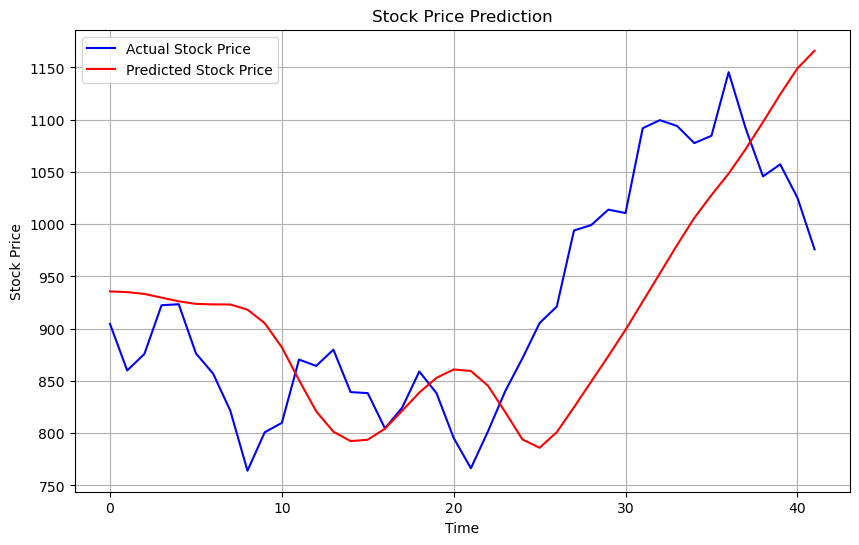

Root Mean Squared Error: 91.55089730180563
Mean Absolute Percentage Error: 0.08171757467091234
Thời gian training mô hình là: 43.96776795387268


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")

print('Thời gian training mô hình là:',training_time)